In [52]:
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import torchvision
import numpy as np

In [53]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float

In [54]:
# Download MNIST using PyTorch

dataset_folder = os.path.join('cached_datasets')

train_data = torchvision.datasets.MNIST(dataset_folder, train=True, transform=None, target_transform=None, download=True)
test_data = torchvision.datasets.MNIST(dataset_folder, train=False, transform=None, target_transform=None, download=True)

In [55]:
x_train = np.array(train_data.data, dtype=np.float)
x_train = x_train.reshape(x_train.shape[0], -1) / 255

x_test = np.array(test_data.data, dtype=np.float)
x_test = x_test.reshape(x_test.shape[0], -1) / 255

y_train = np.array(train_data.targets, dtype=np.long)
y_test = np.array(test_data.targets, dtype=np.long)

In [56]:
def current_to_firing_time(x, tau=20, threshold=.2, tmax=1.0, epsilon=1e-7):
    index = x < threshold
    x = np.clip(x, threshold + epsilon, 1e9)
    t = tau * np.log(x / (x - threshold))
    t[index] = tmax
    return t

def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, time_step, shuffle=True):
    """ This generator takes datasets in analog format and generates spiking network input as sparse tensors.

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """
    labels_ = np.array(y,dtype=np.long)
    number_of_batches = len(X)//batch_size
    sample_index = np.arange(len(X))
    # compute discrete firing times
    tau_eff = 20e-3/time_step
    firing_times = np.array(current_to_firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=np.long)
    unit_numbers = np.arange(nb_units)

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]

        coo = [ [] for _ in range(3) ]
        for bc,idx in enumerate(batch_index):
            c = firing_times[idx]<nb_steps
            times, units = firing_times[idx][c], unit_numbers[c]

            batch = [bc for _ in range(len(times))]
            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].extend(units)

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)

        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index], device=device, dtype=torch.long)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1


class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply


In [57]:
class SpikingNetwork:

    def __init__(self, unit_count: List[int], weight_scale=1.0, tau_membrane=5e-3, tau_synapse=10e-3,
                 time_step_s=1e-3, spike_fn = SurrGradSpike.apply):
        self.layer_weights = []
        self.unit_count = unit_count
        self.weight_scale = weight_scale
        self.spike_fn = spike_fn
        self.tau_membrane = tau_membrane
        self.tau_synapse = tau_synapse
        self.time_step = time_step_s
        self.alpha = float(np.exp(-self.time_step / self.tau_synapse))
        self.beta = float(np.exp(-self.time_step / self.tau_membrane))

        for i in range(len(unit_count) - 1):
            # creates weights for pair (ci, c(i+1)) for i from {0, 1, 2, ..., len(C) - 2}
            weights = torch.empty((unit_count[i], unit_count[i+1]), device=device, dtype=dtype, requires_grad=True)
            self.layer_weights.append(weights)

        self.randomize_weights()

    def randomize_weights(self):
        for i in range(len(self.layer_weights)):
            torch.nn.init.normal_(self.layer_weights[i], mean=0.0, std=self.weight_scale / np.sqrt(self.unit_count[i]))

    def run(self, inputs, batch_size, num_steps):
        current_spikes = inputs
        for i in range(len(self.layer_weights) - 1):
            hi = torch.einsum('abc, cd -> abd', (current_spikes, self.layer_weights[i]))
            syn = torch.zeros((batch_size, self.unit_count[i+1]), device=device, dtype=dtype)
            mem = torch.zeros((batch_size, self.unit_count[i+1]), device=device, dtype=dtype)

            mem_rec = [mem]
            spike_rec = [mem]

            # compute activity
            for dt in range(num_steps):
                mthr = mem - 1.0
                out = spike_fn(mthr)
                rst = torch.zeros_like(mem)
                c = (mthr > 0)
                rst[c] = torch.ones_like(mem)[c]

                new_syn = self.alpha * syn + hi[:, dt]
                new_mem = self.beta * mem + syn - rst

                mem = new_mem
                syn = new_syn

                mem_rec.append(mem)
                spike_rec.append(out)

            current_spikes = spike_rec
            current_spikes = torch.stack(mem_rec, dim=1)

        # readout


        h_final = torch.einsum('abc, cd -> abd', (current_spikes, self.layer_weights[-1]))
        flt = torch.zeros((batch_size, self.unit_count[-1]), device=device, dtype=dtype)
        out = torch.zeros((batch_size, self.unit_count[-1]), device=device, dtype=dtype)
        out_rec = [out]
        for dt in range(num_steps):
            new_flt = self.alpha * flt + h_final[:, dt]
            new_out = self.beta * out + flt

            flt = new_flt
            out = new_out

            out_rec.append(out)

        out_rec = torch.stack(out_rec, dim=1)
        return out_rec

    def train(self, x_data, y_data, batch_size, num_steps, lr=2e-3, num_epochs=10):
        params = self.layer_weights
        optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9, 0.999))

        log_softmax_fn = torch.nn.LogSoftmax(dim=1)
        loss_fn = torch.nn.NLLLoss()

        loss_hist = []
        for epoch in range(num_epochs):
            local_loss = []

            for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, num_steps, self.unit_count[0],
                                                          self.time_step):
                output = self.run(x_local.to_dense(), batch_size, num_steps)
                m, _ = torch.max(output, 1)
                log_p_y = log_softmax_fn(m)
                loss_val = loss_fn(log_p_y, y_local)

                optimizer.zero_grad()
                loss_val.backward()
                optimizer.step()
                local_loss.append(loss_val.item())

            mean_loss = np.mean(local_loss)
            loss_hist.append(mean_loss)
            print('Epoch {}: loss={:.5f}'.format(epoch + 1, mean_loss))

        return loss_hist

    def eval_acc(self, x, y, batch_size, num_steps):
        accs = []
        for x_local, y_local in sparse_data_generator(x, y, batch_size, num_steps,
                                                      self.unit_count[0], time_step=self.time_step, shuffle=False):
            output = self.run(x_local.to_dense(), batch_size, num_steps)
            m, _ = torch.max(output, 1)
            _, argmax = torch.max(m, 1)
            temp = np.mean((y_local == argmax).detach().cpu().numpy())
            accs.append(temp)

        return np.mean(accs)

Epoch 1: loss=11.49155
Epoch 2: loss=2.33085
Epoch 3: loss=2.30129
Epoch 4: loss=2.22890
Epoch 5: loss=2.19863
Epoch 6: loss=2.17300
Epoch 7: loss=2.14744
Epoch 8: loss=2.12185
Epoch 9: loss=2.10774
Epoch 10: loss=2.09915
Epoch 11: loss=2.09005
Epoch 12: loss=2.08258
Epoch 13: loss=2.02993
Epoch 14: loss=1.97544
Epoch 15: loss=1.88866
Epoch 16: loss=1.84791
Epoch 17: loss=1.81800
Epoch 18: loss=1.76544
Epoch 19: loss=1.73676
Epoch 20: loss=1.72094
Epoch 21: loss=1.71237
Epoch 22: loss=1.70294
Epoch 23: loss=1.71293
Epoch 24: loss=1.69626
Epoch 25: loss=1.69917
Epoch 26: loss=1.72454
Epoch 27: loss=1.71793
Epoch 28: loss=1.71888
Epoch 29: loss=1.69712
Epoch 30: loss=1.68952


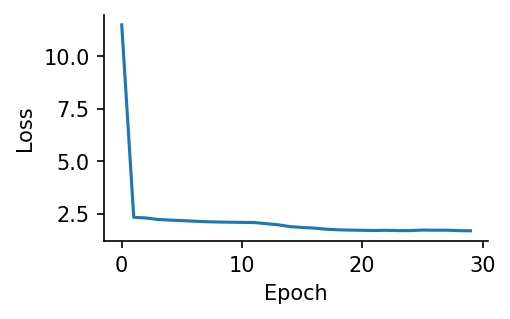

In [58]:
neurons = [28*28, 100, 100, 10]
tau_mem, tau_syn = 10e-3, 5e-3
batch_size = 256
time_step_dur,num_steps = 1e-3, 100

weight_scale = 7 * (1.0 - float(np.exp(-time_step_dur/tau_mem)))
steps = 100
model = SpikingNetwork(neurons, weight_scale=weight_scale, tau_membrane=tau_mem,
                       tau_synapse=tau_syn, time_step_s=time_step_dur)

hist = model.train(x_train, y_train, batch_size, num_steps=num_steps, num_epochs=30, lr=2e-4)

plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [59]:
train_acc = model.eval_acc(x_train, y_train, batch_size, num_steps)
test_acc = model.eval_acc(x_test, y_test, batch_size, num_steps)

print('Training accuracy: {:.5f}'.format(train_acc))
print('Testing accuracy: {:.5f}'.format(test_acc))

Training accuracy: 0.39151
Testing accuracy: 0.38792
